In [1]:
import numpy as np
import pandas as pd
import os
import sys
import requests
import json
from tabulate import tabulate
from datetime import datetime
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
key = "RF3AMXIFA1Q8TR5D62Y65C1PZBPI46TQKFx"

In [3]:
def callApi(url):
    response = requests.get(url = url)
    data = response.json()
    
    if data["message"] == "OK":
        return data["result"]
    
#     print("Request failed", data)
    return []

In [4]:
def getTxns(addr):
    url = "https://api.etherscan.io/api?module=account&action=txlist&address=%s&startblock=0&endblock=99999999&sort=desc&apikey=%s" \
    % (addr, key)
    result = callApi(url)
    return result

In [5]:
platforms = {
    "Curve": ["0xd533a949740bb3306d119cc777fa900ba034cd52"],
    "Convex Finance":  ["0xf403c135812408bfbe8713b5a23a04b3d48aae31", "0x3fe65692bfcd0e6cf84cb1e7d24108e434a7587e", "0xcf50b810e57ac33b91dcf525c6ddd9881b139332", "0x8014595f2ab54cd7c604b00e9fb932176fdc86ae", "0x92cf9e5e4d1dfbf7da0d2bb3e884a68416a65070", "0xd18140b4b819b895a3dba5442f959fa44994af50", "0x5f465e9fcffc217c5849906216581a657cd60605", "0xe98984ad858075813ada4261af47e68a64e28fcc"], 
    "Uniswap": ["0x1f9840a85d5af5bf1d1762f925bdaddc4201f984"],
    "AAVE": ["0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9"],
    "Compound": ["0xc00e94cb662c3520282e6f5717214004a7f26888"],
    "Lido": ["0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84"],
    "Instadapp": ["0x2971adfa57b20e5a416ae5a708a8655a9c74f723", "0x4c8a1BEb8a87765788946D6B19C6C6355194AbEb", "0xFE02a32Cbe0CB9ad9A945576A5bb53A3C123A3A3", "0x97b0B3A8bDeFE8cB9563a3c610019Ad10DB8aD11", "0x8a5419CfC711B2343c17a6ABf4B2bAFaBb06957F", "0xCBA828153d3a85b30B5b912e1f2daCac5816aE9D", "0x619Ad2D02dBeE6ebA3CDbDA3F98430410e892882", "0x33759cF68a3Ab9e8d582d8A4717104848E0fa8B9", "0x28849D2b63fA8D361e5fc15cB8aBB13019884d09"],
    "Yearn Finance": ["0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e"],
    "SushiSwap": ["0x6b3595068778dd592e39a122f4f5a5cf09c90fe2"],
    "Balancer": ["0xba100000625a3754423978a60c9317c58a424e3D"],
    
    "OpenSea": ["0x7Be8076f4EA4A4AD08075C2508e481d6C946D12b", "0x7f268357A8c2552623316e2562D90e642bB538E5"],
    "SuperRare": ["0x6D7c44773C52D396F43c2D511B81aa168E9a7a42"],
    "Looks Rare": ["0xf4d2888d29d722226fafa5d9b24f9164c092421e"],
    "Rarible": ["0xfca59cd816ab1ead66534d82bc21e7515ce441cf"],
    "NiftyGateway": ["0xE052113bd7D7700d623414a0a4585BCaE754E9d5", "0x11ab0243c57C6c1b39F2908AAeBaed7ccf351491"],
    "Foundation": ["0xcDA72070E455bb31C7690a170224Ce43623d0B6f"]
}

In [6]:
def getPlatformsTxns(platforms, dirPath):
    for platform in platforms:
        result = []
        for addr in platforms[platform]:
            result = result + getTxns(addr)

        file = os.path.join(dirPath, "%s.json" % (platform)) 
        with open(file, "w") as f:
            f.write(json.dumps(result))
            
getPlatformsTxns(defi, "data/defi/contractsTxns_04_04")

Request failed {'status': '0', 'message': 'No transactions found', 'result': []}


In [6]:
def getTxnsUsers(dirPath, filePath):
    users = set({})

    for path, dirs, files in os.walk(dirPath):
        for file in files:
            filePath = os.path.join(dirPath, file)
            
            with open(filePath, "r") as f:
                data = json.load(f)
                currUsers = [x["from"] for x in data]
                currUsers = set(currUsers)
                users = users.union(currUsers)
                
    with open(filePath, "w") as f:
        for user in users:
            f.write(user)
            f.write("\n")
    
    return users

defiUsers = getTxnsUsers("data/defi/contractsTxns_04_04", "data/defi/users/defiUsers_04_04.txt")
print(len(defiUsers))

JSONDecodeError: Extra data: line 1 column 2 (char 1)

In [6]:
def getAllUsers(dirPath):
    allUsers = set({})

    for path, dirs, files in os.walk(dirPath):
        for file in files:
            filePath = os.path.join(path, file)

            with open(filePath, "r") as f:
                users = f.readlines()
                users = set([x[:-1] for x in users])
                allUsers = allUsers.union(users)

    return allUsers

In [7]:
allDefiUsers = getAllUsers("data/defi/users")
print("DeFi Users:", len(allDefiUsers))

allNftUsers = getAllUsers("data/nft/users")
print("NFT Users:", len(allNftUsers))

allUsers = allDefiUsers.union(allNftUsers)
commonUsers = allDefiUsers.intersection(allNftUsers)
print("All Users:", len(allUsers))
print("Common Users:", len(commonUsers))

DeFi Users: 69763
NFT Users: 44962
All Users: 113210
Common Users: 1515


### Splitting Data for Parallelization

In [8]:
def splitUsers(allUsers, divs=6):
    subsets = np.array_split(list(allUsers), divs)
    for i in range(len(subsets)):
        subset = subsets[i]
        strg = "\n".join(subset)
        
        filePath = "data/combinedUsers/%d.txt" % (i)
        with open(filePath, "w") as f:
            f.write(strg)

splitUsers(allUsers)

In [8]:
def getUsersSubset(filePath):
    with open(filePath, "r") as f:
        users = f.readlines()
        users = set([x[:-1] for x in users])
        return users

subUsers = getUsersSubset("data/combinedUsers/0.txt")
print(len(subUsers))

18869


### Extract Features from Users' Transactions

In [9]:
def getBal(addr):
    url = "https://api.etherscan.io/api?module=account&action=balance&address=%s&tag=latest&apikey=%s" % (addr, key)
    bal = float(callApi(url)) / 1e18
    return bal

In [10]:
def getAvgTxnsPerDay(txns, denom = 0):
    timestamps = [int(x["timeStamp"]) for x in txns]
    df = pd.DataFrame(timestamps)
    df[0] = df[0].apply(lambda x: datetime.fromtimestamp(x))
    group = df.groupby([df[0].dt.date]).describe(datetime_is_numeric=True)
    if not denom:
        denom = len(group[(0, 'count')])

    avg_tx_per_day = sum(group[(0, 'count')]) / denom
    return avg_tx_per_day, denom

In [11]:
def getTokenTransfers(addr):
    url = "https://api.etherscan.io/api?module=account&action=tokentx&address=%s&startblock=0&endblock=99999999&sort=desc&apikey=%s" % (addr, key)
    txns = callApi(url)
    
    tokens = {}
    
    for i in txns:
        if i["tokenName"] not in tokens:
            tokens[i["tokenName"]] = {"buys": 0, "sells": 0}
        
        if i['from'] == addr:
            tokens[i["tokenName"]]["sells"] += 1
        else:
            tokens[i["tokenName"]]["buys"] += 1
        
    return tokens

In [12]:
def getNFTTransfers(addr):
    url = "https://api.etherscan.io/api?module=account&action=tokennfttx&address=%s&startblock=0&endblock=99999999&sort=desc&apikey=%s" % (addr, key)
    txns = callApi(url)
    
    nfts = {}
    
    for i in txns:
        if i["tokenName"] not in nfts:
            nfts[i["tokenName"]] = {"buys": 0, "sells": 0}
            
        if i['from'] == addr:
            nfts[i["tokenName"]]["sells"] += 1
        else:
            nfts[i["tokenName"]]["buys"] += 1
            
    return nfts

In [13]:
def clusterTxns(txns, platforms, currAddr):
    finalDict = {}
    platformsTxns = {}
    platAddrMap = {}
    for platform in platforms:
        platformsTxns[platform] = []
        
        for addr in platforms[platform]:
            platAddrMap[addr] = platform
    
    for txn in txns:
        fromAddr = txn["from"]
        toAddr = txn["to"]
        
        if fromAddr != currAddr:
            if fromAddr not in finalDict:
                finalDict[fromAddr] = 0
            finalDict[fromAddr] += 1
            
            if fromAddr in platAddrMap.keys():
                platform = platAddrMap[fromAddr]
                platformsTxns[platform].append(txn)
            
        elif toAddr != currAddr:
            if toAddr not in finalDict:
                finalDict[toAddr] = 0
            finalDict[toAddr] += 1
            
            if toAddr in platAddrMap.keys():
                platform = platAddrMap[toAddr]
                platformsTxns[platform].append(txn)
            
    return finalDict, platformsTxns

In [30]:
def getPlatformCounts(clusters, platforms, dayCount):
    counts = {}
    avgs = {}
    
    for platform in platforms:
        ctr = 0
        for addr in platforms[platform]:
            if addr in list(clusters.keys()):
                ctr += clusters[addr]
        
        if not ctr:
            continue
        counts[platform] = ctr
        avgs[platform] = ctr / dayCount
            
    return counts, avgs

In [16]:
def getUserCounts(clusters, defiUsers, nftUsers):
    defiCommon = set(defiUsers).intersection(set(clusters.keys()))
    nftCommon = set(nftUsers).intersection(set(clusters.keys()))
    counts = {
        "DEFI": {
            "User Count": len(defiCommon),
            "Transaction Count": 0
        },
        "NFT": {
            "User Count": len(nftCommon),
            "Transaction Count": 0
        }
    }
    
    for user in defiCommon:
        counts["DEFI"]["Transaction Count"] += clusters[user]
        
    for user in nftCommon:
        counts["NFT"]["Transaction Count"] += clusters[user]
    
    return counts

In [17]:
def isContract(addr):
    url = "https://api.etherscan.io/api?module=contract&action=getabi&address=%s&apikey=%s" % (addr, key)
    result = callApi(url)
    if result == []:
        return False
    
    return True

In [18]:
def parseOtherAddrs(clusters, platforms, allUsers):
    counts = {}
    platAddrs = []
    for platform in platforms:
        for addr in platforms[platform]:
            platAddrs.append(addr)
            
    for addr in clusters:
        if addr in allUsers or addr in platAddrs:
            continue
            
#         if isContract(addr):
        counts[addr] = clusters[addr]
            
    return counts

In [31]:
def getUserFeats(addr):
    bal = getBal(addr)
    txns = getTxns(addr)
    avgTxnsPerDay, dayCount = getAvgTxnsPerDay(txns)
    clusters, platformsTxns = clusterTxns(txns, platforms, addr)
    platformCounts, platformAvgs = getPlatformCounts(clusters, platforms, dayCount)
    userCounts = getUserCounts(clusters, allDefiUsers, allNftUsers)
    otherPlatformsCount = parseOtherAddrs(clusters, platforms, allUsers)
    tokenTransfers = getTokenTransfers(addr)
    nftTransfers = getNFTTransfers(addr)
    
    feats = {
        "Ether Balance": bal,
        "Overall Transaction Count": len(txns),
        "Average Transactions Per Day": avgTxnsPerDay,
        "Platform Transaction Count": platformCounts,
        "Platform Average Transactions Per Day": platformAvgs,
        "User Counts": userCounts,
        "Other Platforms Count": otherPlatformsCount,
        "Token Transfers": tokenTransfers,
        "NFT Transfers": nftTransfers   
    }
    
    return feats

In [32]:
allFeats = {}

In [33]:
def getAllUsersFeats(users, filePath):
    global allFeats
    
    with open(filePath, "a") as f:
        if allFeats == {}:
            f.write("{")
        
        for user in tqdm(users):
            if user in allFeats.keys():
                continue
                
            feats = getUserFeats(user)
            allFeats[user] = feats
            f.write("\"%s\": " % (user) + json.dumps(feats) + ", ")

    f.write("}")
    return allFeats

getAllUsersFeats(subUsers, "data/combinedUsers/userFeats1.json")

  0%|                                      | 1/18869 [00:09<49:17:38,  9.41s/it]


KeyboardInterrupt: 

In [22]:
print(tabulate([
    ["DEFI Unique Users", len(allUsers)],
    ["NFT Unique Users", len(nftUsers)],
    ["Common Users", len(commonUsers)],
    ["Total Unique Users", len(combinedUsers)]],
    headers=["Label", "Count"]))

Label                 Count
------------------  -------
DEFI Unique Users     50124
NFT Unique Users      28087
Common Users            762
Total Unique Users    77449


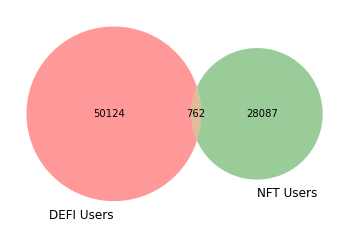

In [24]:
venn2(subsets = (len(allUsers), len(nftUsers), len(commonUsers)), set_labels = ('DEFI Users', 'NFT Users'))